# Load Modules

In [1]:
import os
import time
import sys
sys.path.append("../Library/")
import random
import numpy as np
import pandas as pd
import math

from PIL import Image
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv("../.env")

# custom modules
import image_download as imd
import image_manipulation as ima
import display as dp
import machine_learning as ml
import deep_learning as dl

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Parameters

In [2]:
# PROCESSING PARAMETERS
MOVE_PROCESSED_IMAGES = True

# IMAGE PARAMETERS
SIZE = 512 # in pixels
BASE_RESOLUTION = 0.3 # in meter

# FOLDER PARAMETERS
GDRIVE_FOLDER = os.getenv('GDRIVE_FOLDER')
MFP_IMAGE_FOLDER = GDRIVE_FOLDER + 'MFP - Satellogic/images/'
RAW_IMAGE_FOLDER = MFP_IMAGE_FOLDER + 'raw_images_usgs_' + str(BASE_RESOLUTION) + 'm/'
IMAGE_FOLDER = MFP_IMAGE_FOLDER + 'usgs_512_res' + str(BASE_RESOLUTION) + 'm/' 

CATEGORIES = ['agriculture', 'shrubland-grassland', 'forest-woodland', 'semi-desert']
LABELS = [0, 1, 2]

## Model

In [3]:
from keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet',include_top=False)

activation_layers = []
for l in base_model.layers:
    l.trainable = False
    if "activation" in l.name or "relu" in l.name:
        activation_layers.append(l.name)
print(activation_layers)

Instructions for updating:
Colocations handled automatically by placer.


/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


['activation_1', 'activation_2', 'activation_3', 'activation_4', 'activation_5', 'activation_6', 'activation_7', 'activation_8', 'activation_9', 'activation_10', 'activation_11', 'activation_12', 'activation_13', 'activation_14', 'activation_15', 'activation_16', 'activation_17', 'activation_18', 'activation_19', 'activation_20', 'activation_21', 'activation_22', 'activation_23', 'activation_24', 'activation_25', 'activation_26', 'activation_27', 'activation_28', 'activation_29', 'activation_30', 'activation_31', 'activation_32', 'activation_33', 'activation_34', 'activation_35', 'activation_36', 'activation_37', 'activation_38', 'activation_39', 'activation_40', 'activation_41', 'activation_42', 'activation_43', 'activation_44', 'activation_45', 'activation_46', 'activation_47', 'activation_48', 'activation_49']


In [19]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Activations

In [27]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_image_and_activations(img, activations, num_filters=8, columns=4, plot_size=4, fname_save = None):
    
    rows = math.ceil(num_filters/columns)
    
    fig = plt.figure(figsize=(plot_size*(columns+1), plot_size*rows))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    #gs = fig.add_gridspec(rows, columns+1)
    gs = gridspec.GridSpec(nrows=rows, ncols=columns+1, figure=fig)
    
    # plot image
    ax = fig.add_subplot(gs[:, 0])
    ax.imshow(img)
    ax.grid()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
        
    # plot activations
    for i in range(num_filters):
        act_row = math.floor(i/columns)
        act_col = i%columns
        ax = fig.add_subplot(gs[act_row, act_col+1])
        ax.matshow(activations[0, :, :, i], cmap='viridis')
        ax.grid()
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        
    fig.tight_layout()
    
    
    if not fname_save is None:
        plt.savefig(fname_save)   
        
    plt.show()
        
    return


def plots_by_category(category, samples, activation_names, labels = [0,2]):
    
    for label in labels:
        imgs = ima.list_path_of_images_by_category_and_label(IMAGE_FOLDER, category, label=label)

        if len(imgs) > 0:
            paths = random.sample(imgs, samples)
            images = [ima.load_image_as_rgb_array(path) for path in paths]

            for i,img in enumerate(images):
                sample = i+1
                for activation_name in activation_names:
                    print("Category: {}, Label: {}, Sample: {}, Activation: {}".format(category, label, sample, activation_name))
                    activations = dl.get_activations(img, base_model, activation_name)
                    plot_image_and_activations(
                        img, activations, 
                        fname_save = filename_formatter.format(category,label,sample,activation_name)
                    )
                
    return


- activation_10:
    - `Shape of input: (1, 512, 512, 3)`
    - `Shape of output: (1, 128, 128, 256)`

- activation_49:
    - `Shape of input: (1, 512, 512, 3)`
    - `Shape of output: (1, 16, 16, 2048)`

In [12]:
samples = 1
activation_names = [activation_layers[i] for i in [9, -1]]
filename_formatter = "../report/Figures/activations/{}_l{}_s{}_{}.png"
print("ACTIVATIONS:", activation_names)

ACTIVATIONS: ['activation_10', 'activation_49']


### Agriculture

Category: agriculture, Label: 2, Sample: 1, Activation: activation_10


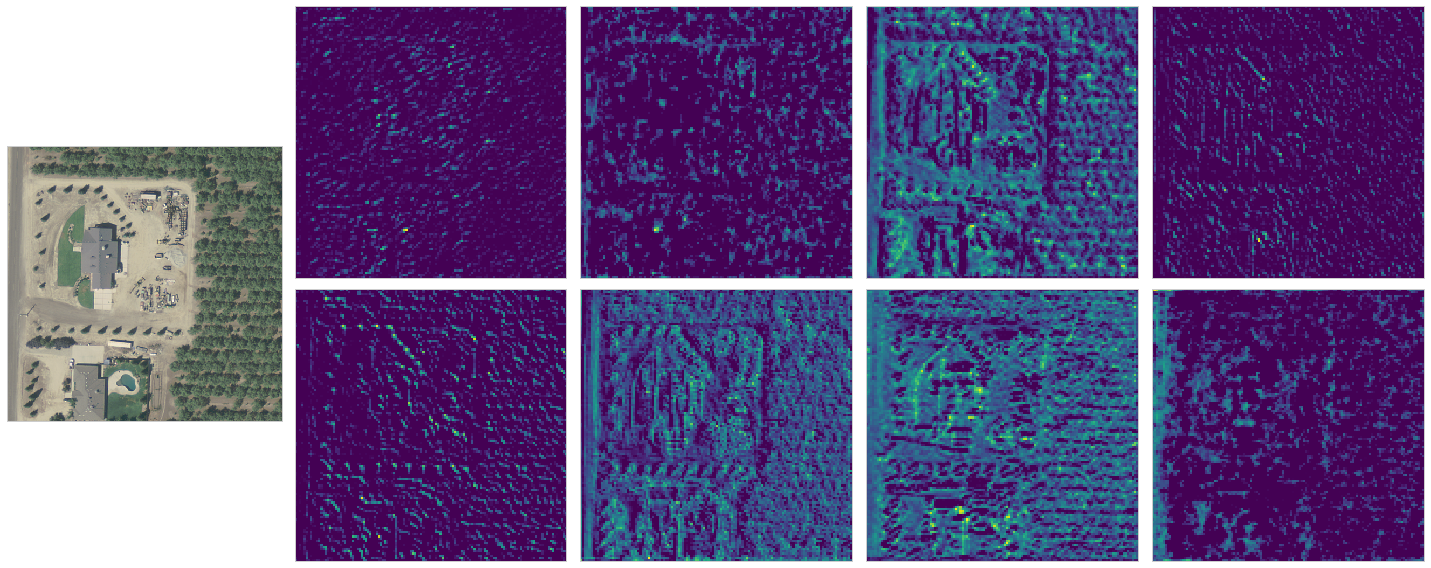

Category: agriculture, Label: 2, Sample: 1, Activation: activation_49


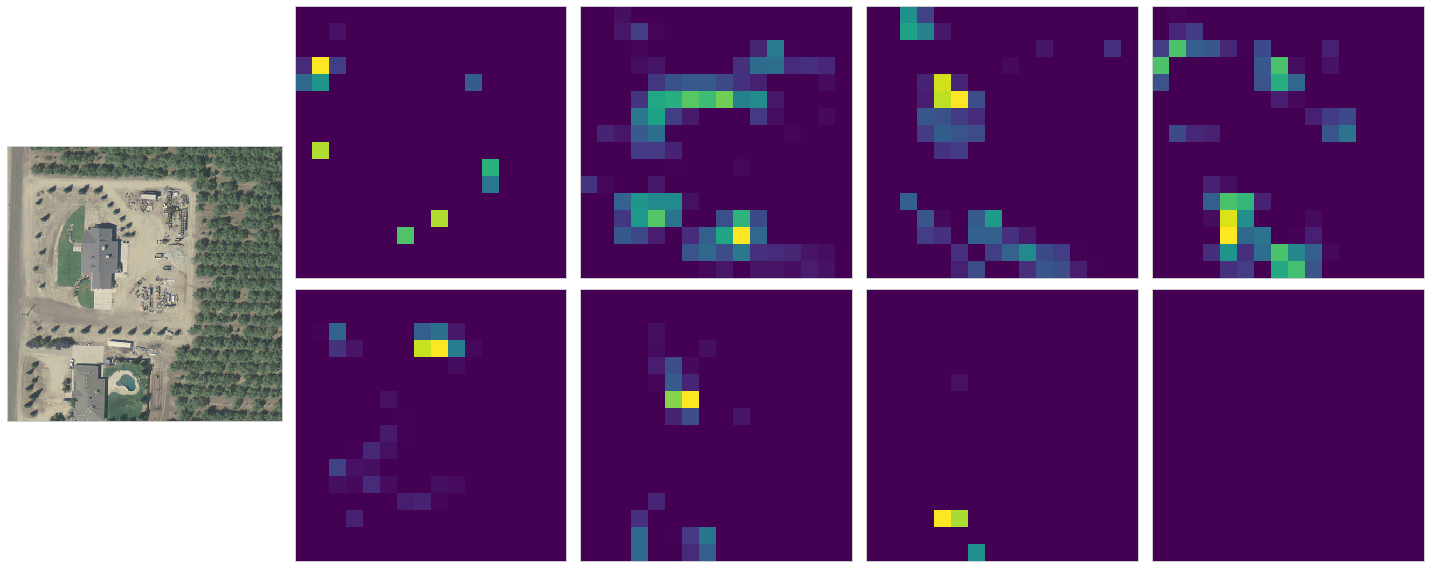

In [13]:
category = 'agriculture'
plots_by_category(category, samples, activation_names)

### shrubland-grassland

Category: shrubland-grassland, Label: 0, Sample: 1, Activation: activation_10


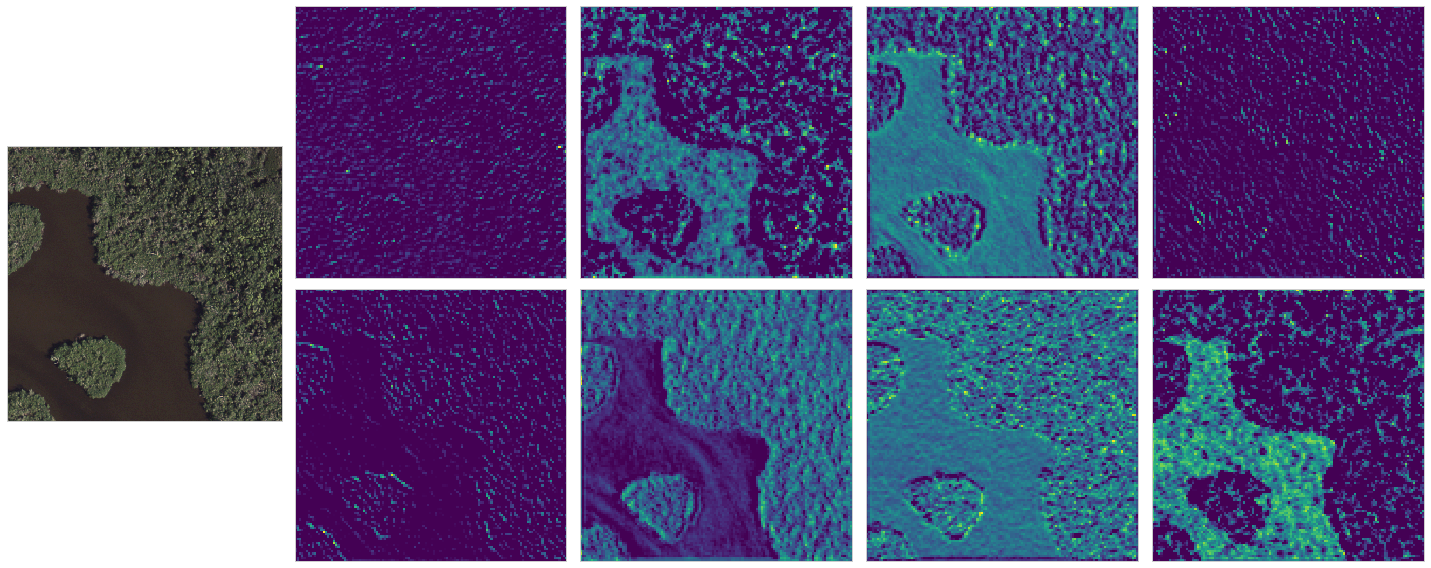

Category: shrubland-grassland, Label: 0, Sample: 1, Activation: activation_49


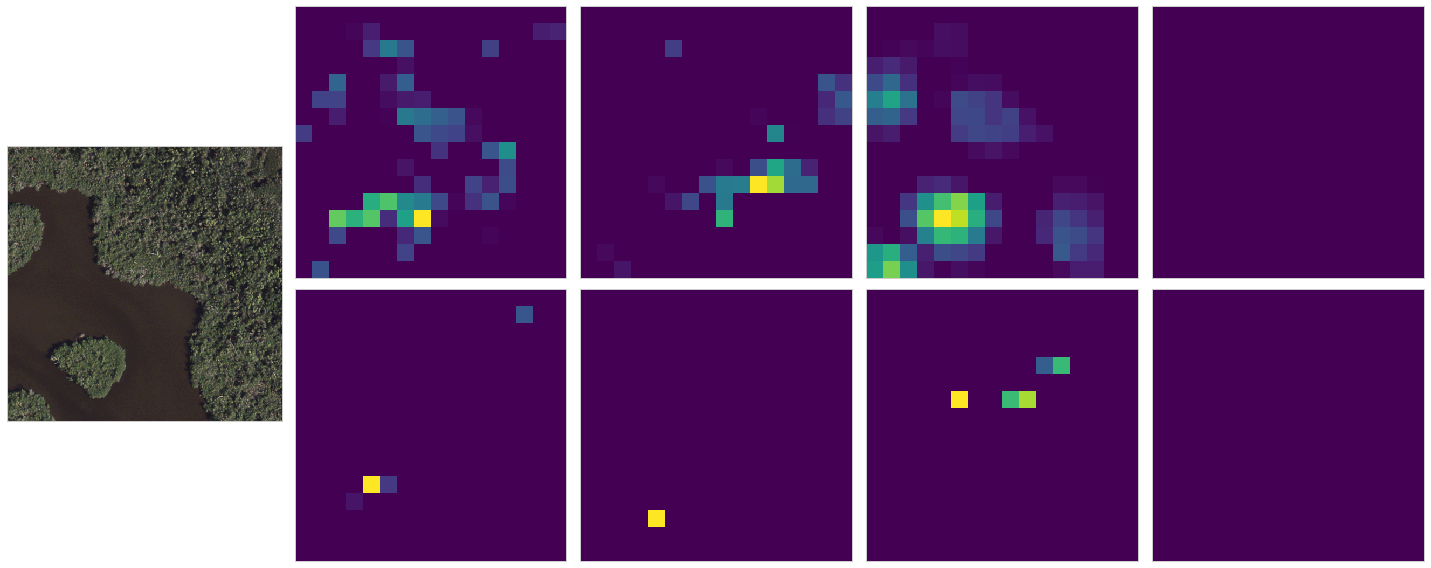

Category: shrubland-grassland, Label: 2, Sample: 1, Activation: activation_10


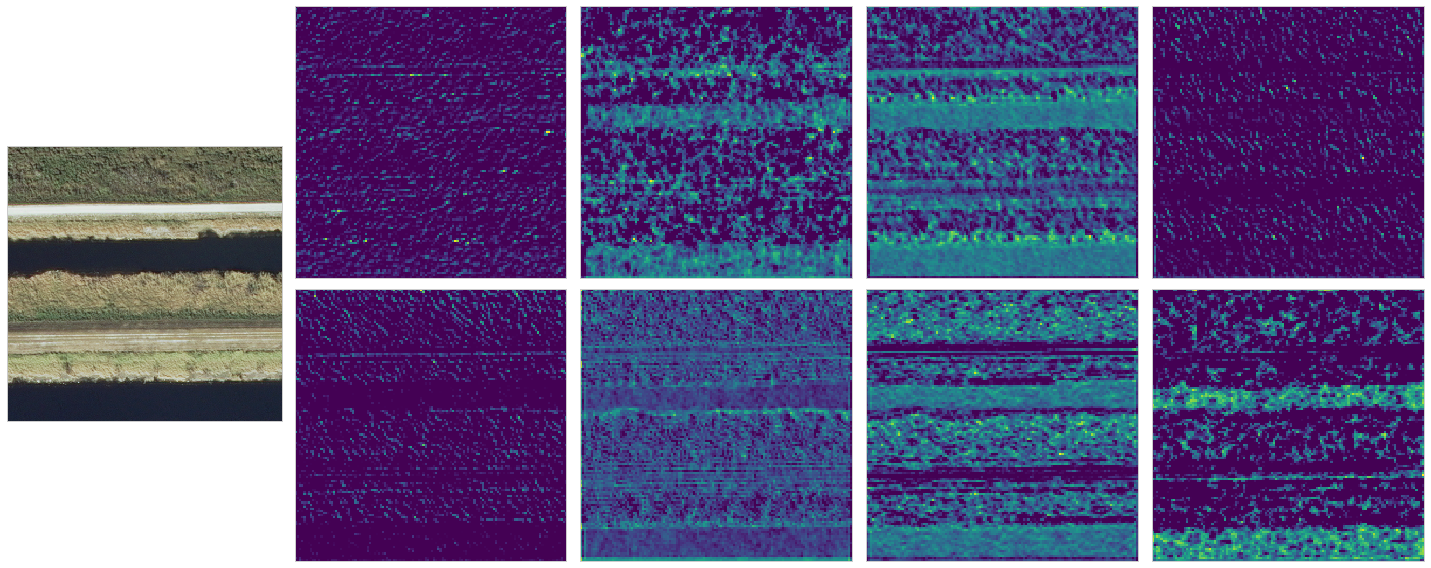

Category: shrubland-grassland, Label: 2, Sample: 1, Activation: activation_49


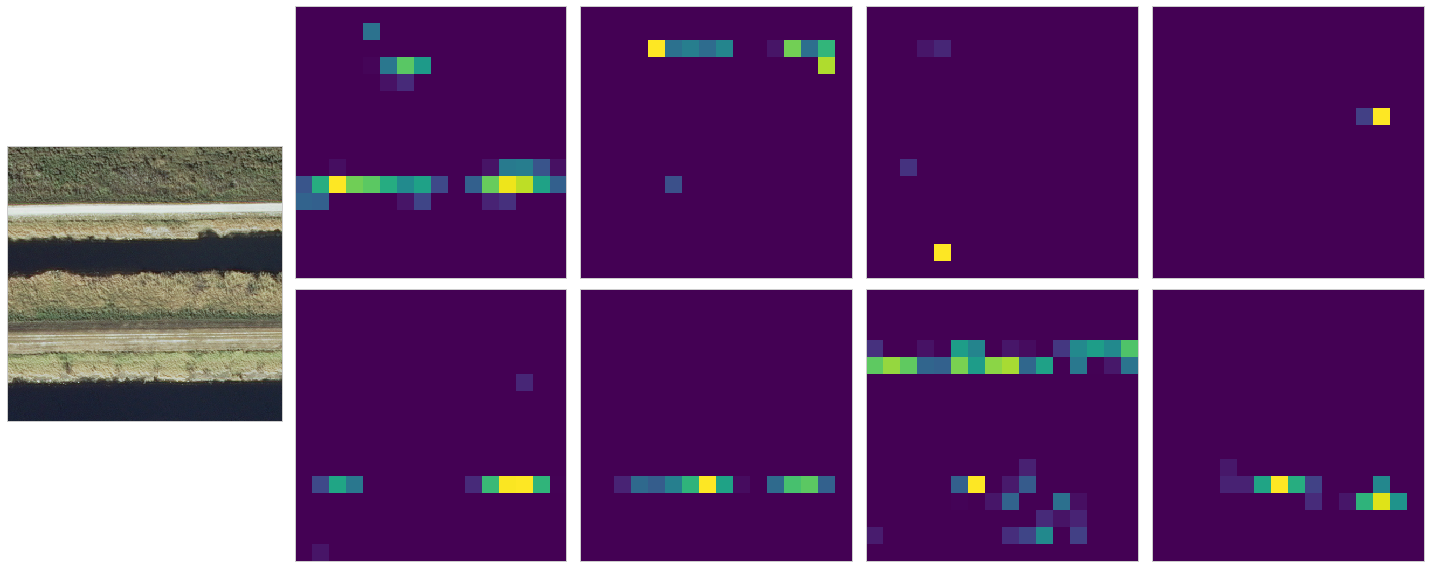

In [14]:
category = 'shrubland-grassland'
plots_by_category(category, samples, activation_names)

### forest-woodland

Category: forest-woodland, Label: 0, Sample: 1, Activation: activation_10


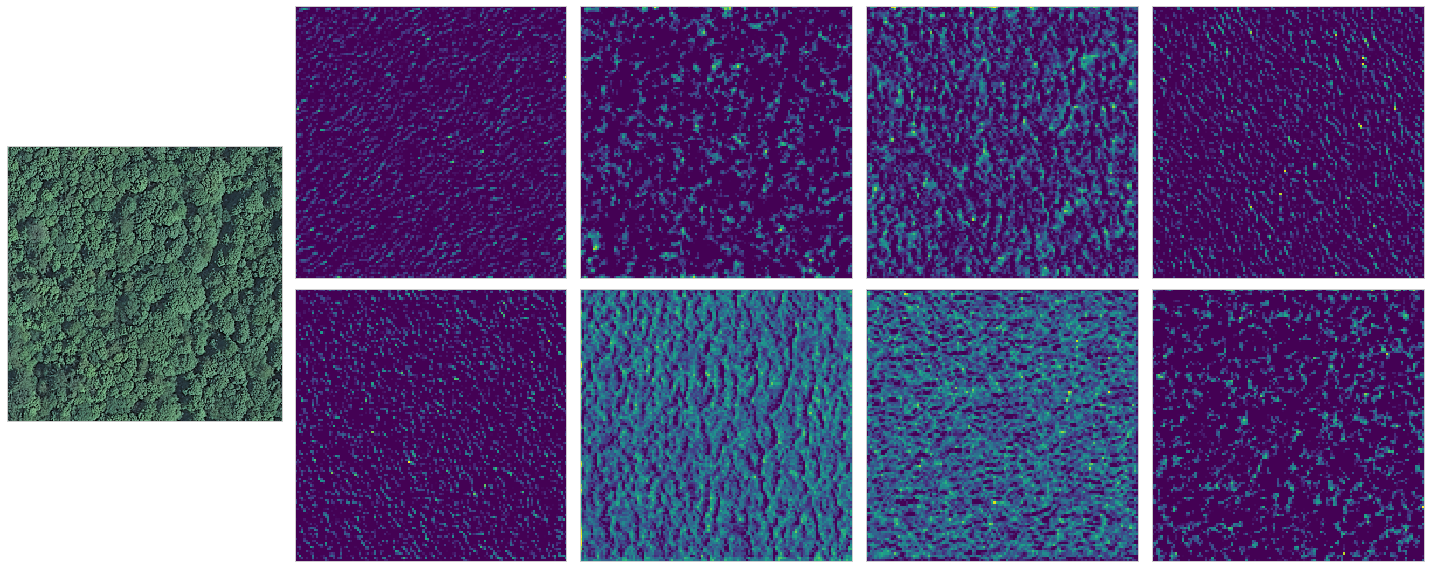

Category: forest-woodland, Label: 0, Sample: 1, Activation: activation_49


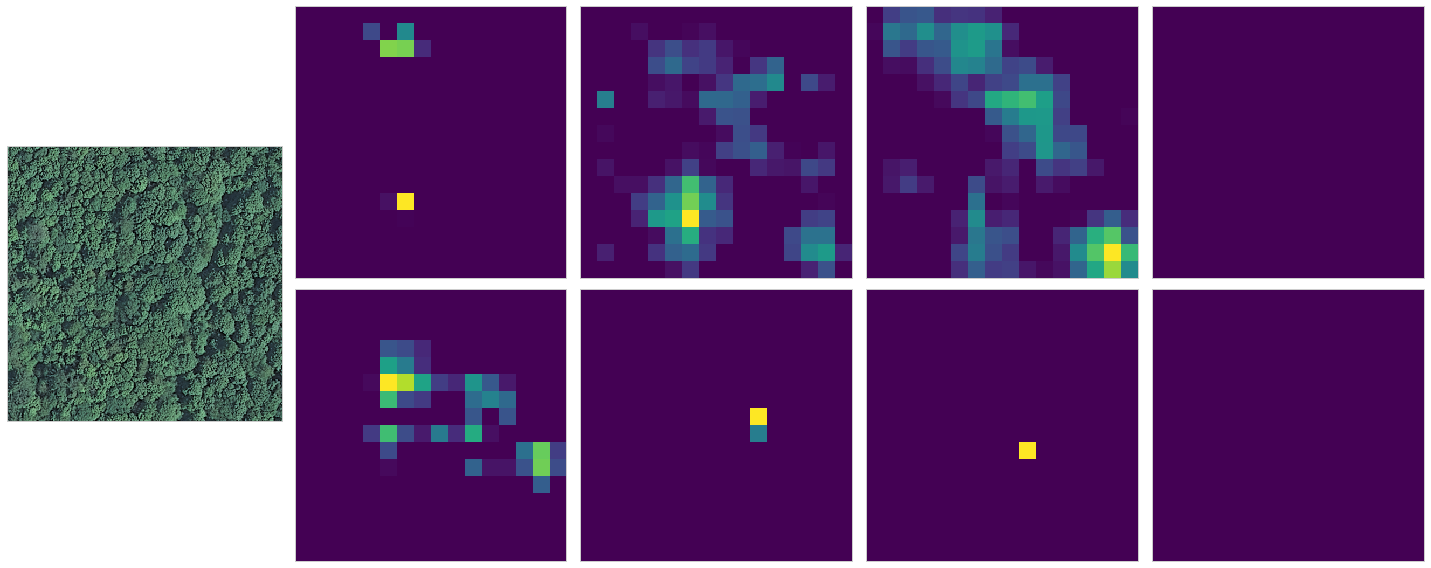

In [32]:
category = 'forest-woodland'
plots_by_category(category, samples, activation_names, labels=[0])

### semi-desert

Category: semi-desert, Label: 0, Sample: 1, Activation: activation_10


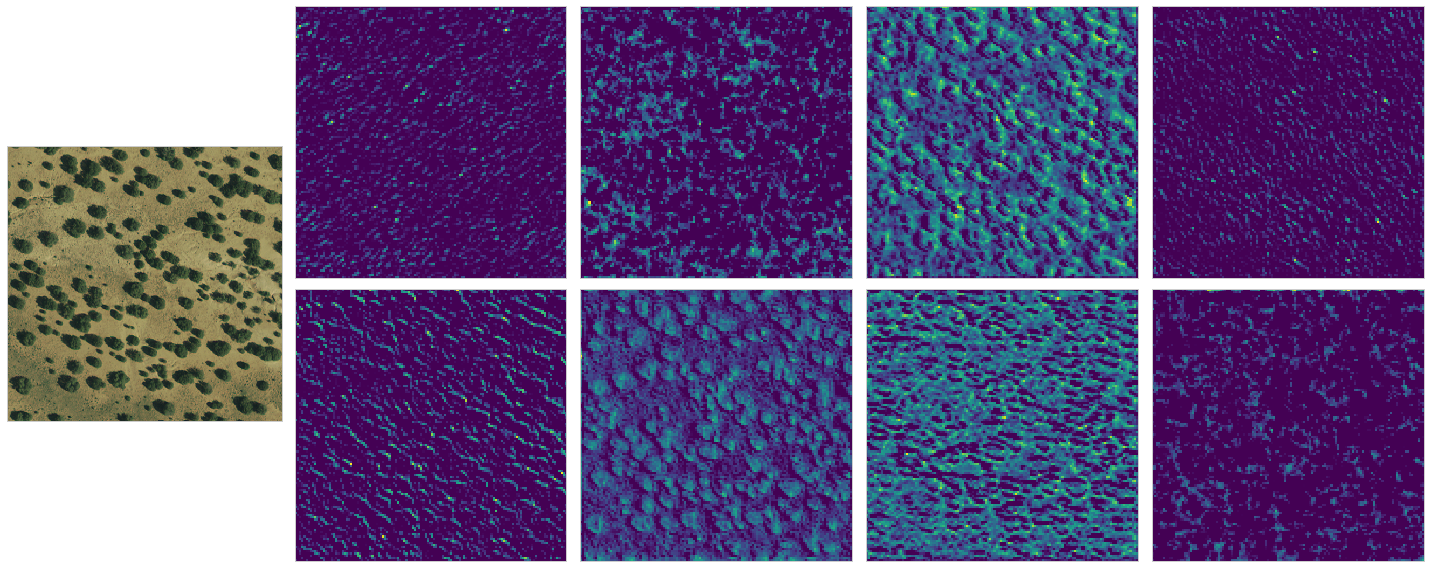

Category: semi-desert, Label: 0, Sample: 1, Activation: activation_49


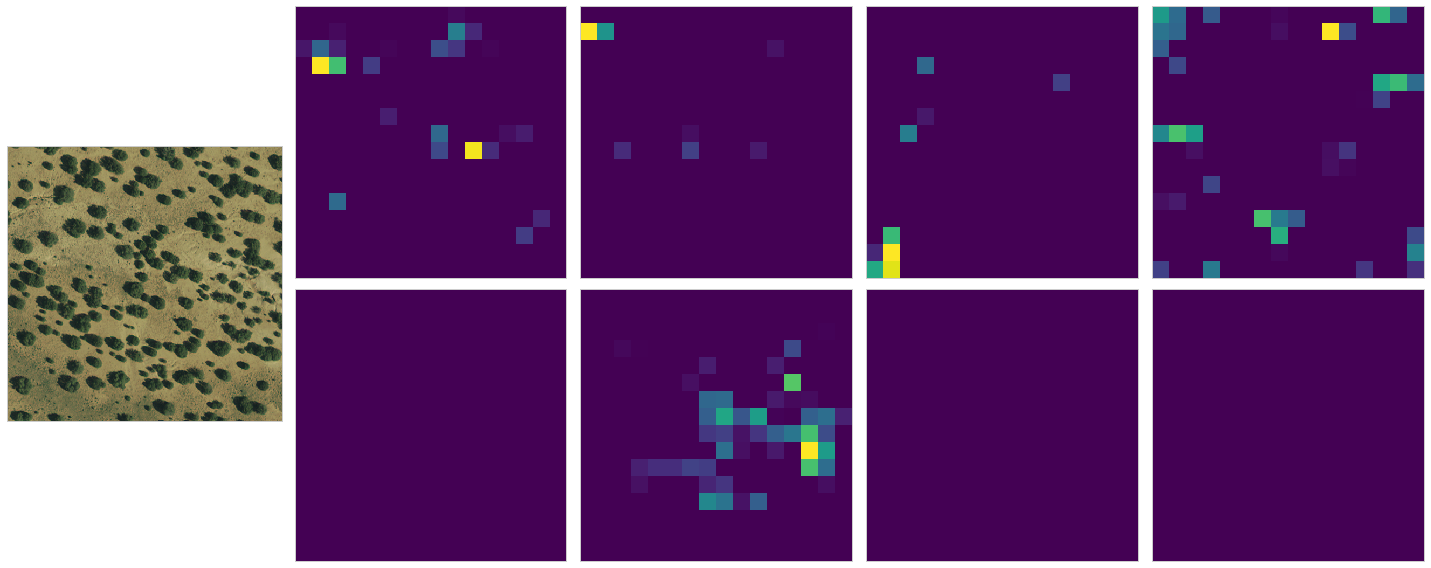

In [37]:
category = 'semi-desert'
plots_by_category(category, samples, activation_names, labels=[0])

### All

In [17]:
fail!!

for category in CATEGORIES[:]:
    plots_by_category(category, samples, activation_names)
                

SyntaxError: invalid syntax (<ipython-input-17-acdb11a11a17>, line 1)